## Graph Recsys research by Sokolov Alexander

In [96]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

In [97]:
# load the data
df = pd.read_csv('netflix_titles.csv')
# конвертируем в datetime
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

In [98]:
# конвертируем колонки 'director, listed_in, cast and country' в колонки в лист с реальным значением
# если значение пропущено, то присваиваем новому значение []
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,8.0,14.0,[],"[International TV Shows, TV Dramas, TV Sci-Fi ...","[João Miguel, Bianca Comparato, Michel Gomes, ...",[Brazil]
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,12.0,23.0,[Jorge Michel Grau],"[Dramas, International Movies]","[Demián Bichir, Héctor Bonilla, Oscar Serrano,...",[Mexico]
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,12.0,20.0,[Gilbert Chan],"[Horror Movies, International Movies]","[Tedd Chan, Stella Chung, Henley Hii, Lawrence...",[Singapore]
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,11.0,16.0,[Shane Acker],"[Action & Adventure, Independent Movies, Sci-F...","[Elijah Wood, John C. Reilly, Jennifer Connell...",[United States]
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0,1.0,1.0,[Robert Luketic],[Dramas],"[Jim Sturgess, Kevin Spacey, Kate Bosworth, Aa...",[United States]


In [99]:
print(df.shape)

(7787, 19)


In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

In [101]:
# Теперь строим матрицу TF-IDF с описанием
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # отбрасывать слова, встречающиеся более чем в X процентах документов
                             min_df=1,      # используем только те слова, которые встречаются не менее X раз
                             stop_words='english', # убираем стоп-слова
                             lowercase=True, # делаем нижний регистр
                             use_idf=True,   # используем IDF 
                             norm=u'l2',     # Нормализуем
                             smooth_idf=True # Предотвращаем ошибки деления на ноль
                            )
tfidf = vector.fit_transform(text_content)

In [102]:
# Теперь используем кластеризацию k-means
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

request_transform = vector.transform(df['description'])
# новая колонка кластера, основанная на описании
df['cluster'] = kmeans.predict(request_transform) 

df['cluster'].value_counts().head()

27     7482
78       11
58        9
53        8
125       7
Name: cluster, dtype: int64

In [103]:
# Теперь ищем похожие: для начала получаем top_n фильмов с описанием, похожим на описание цели 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

In [104]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))        

 iter 0 -- 0.05979490280151367 seconds --
 iter 1000 -- 4.880735874176025 seconds --
 iter 2000 -- 9.225124835968018 seconds --
 iter 3000 -- 13.625595808029175 seconds --
 iter 4000 -- 18.184895992279053 seconds --
 iter 5000 -- 22.625508785247803 seconds --
 iter 6000 -- 27.072516679763794 seconds --
 iter 7000 -- 31.477247953414917 seconds --
 finish -- 34.93803000450134 seconds --


In [105]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

### Строим субграфы по фильмам

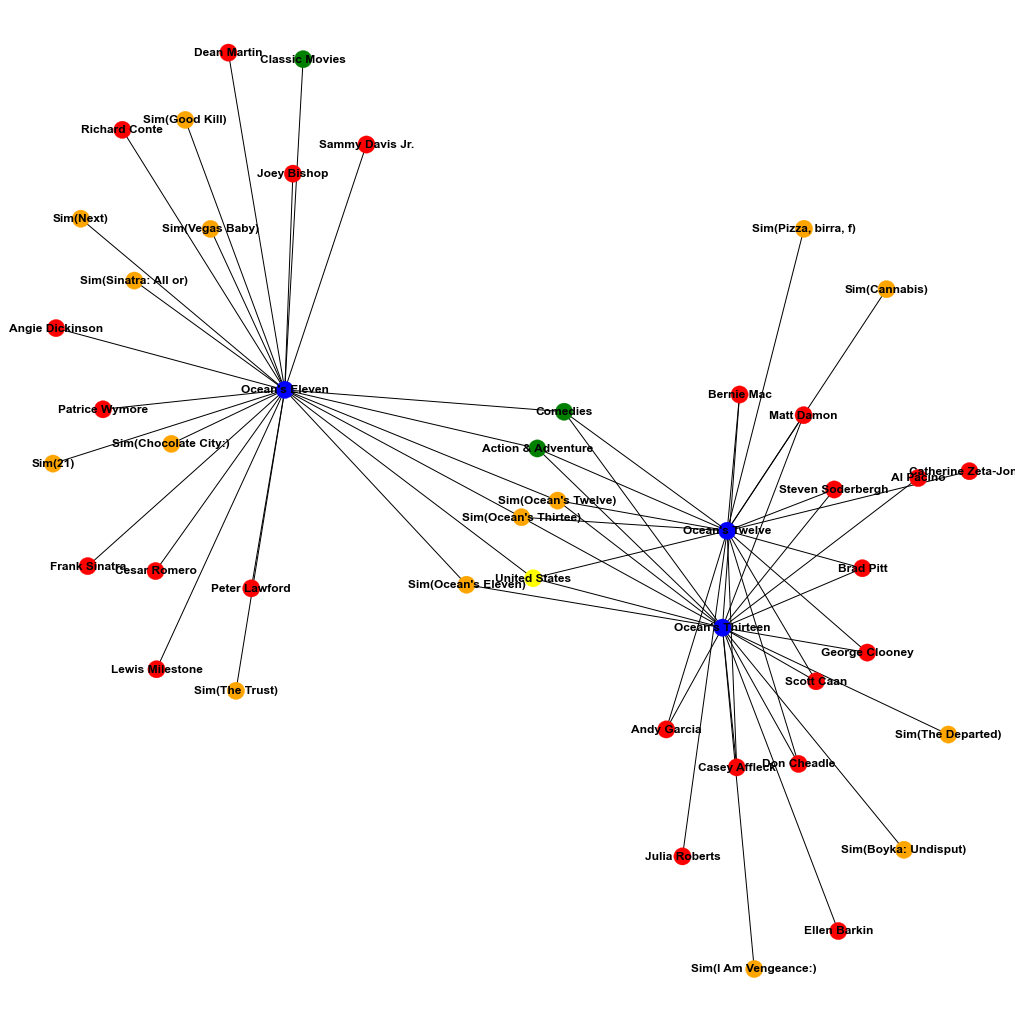

In [106]:
list_in=["Ocean's Eleven","Ocean's Thirteen","Ocean's Twelve"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

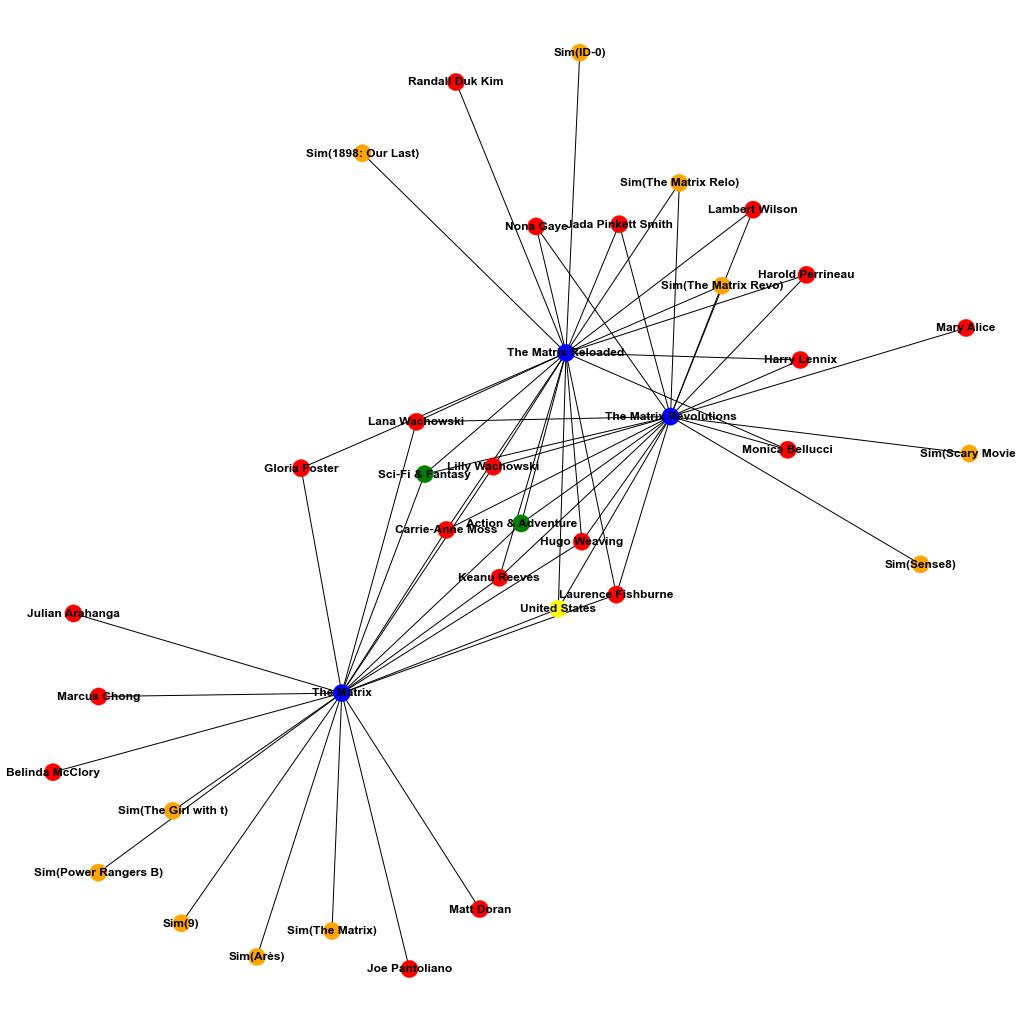

In [107]:
list_in=["The Matrix","The Matrix Reloaded",'The Matrix Revolutions']
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

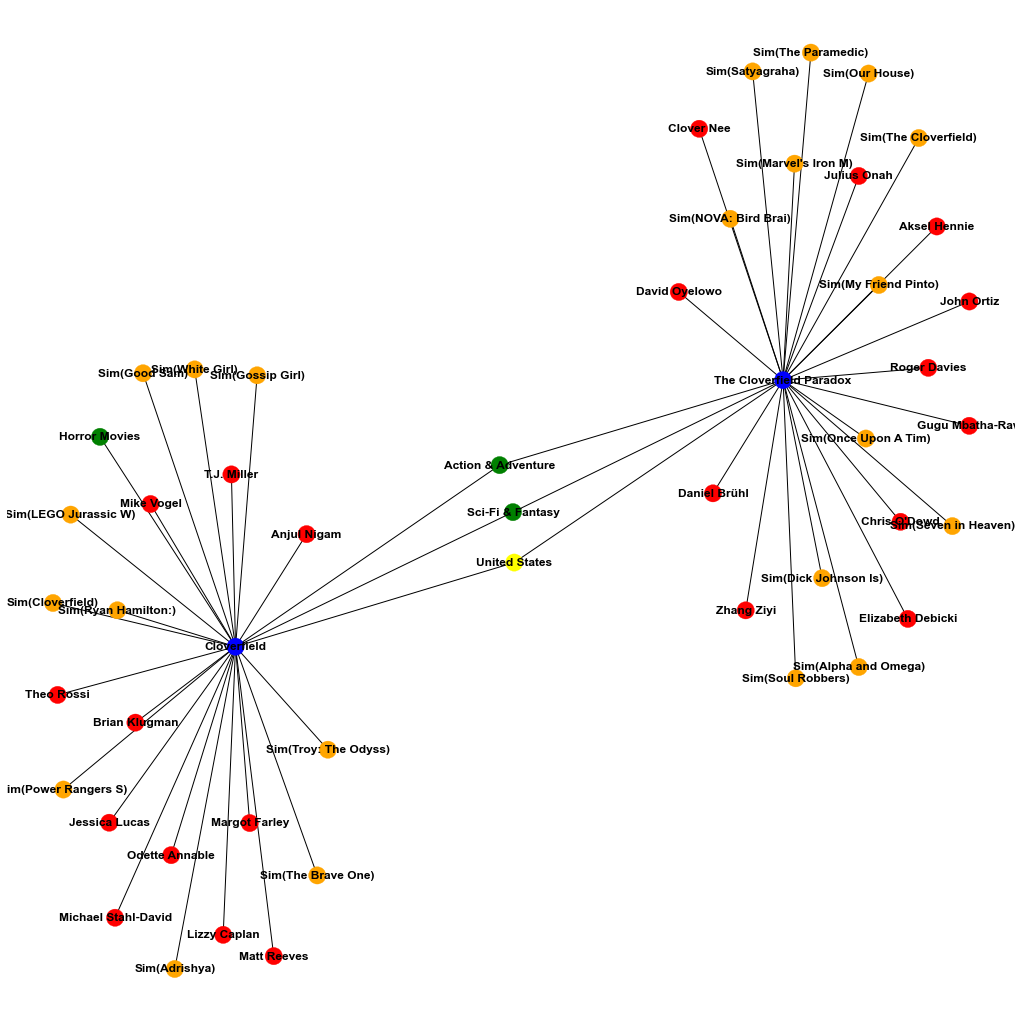

In [108]:
list_in=["Cloverfield",'The Cloverfield Paradox']
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [109]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

### Составляем рекомендации к фильмам

In [110]:
result = get_recommendation("Ocean's Eleven")
result2 = get_recommendation("Cloverfield")
result3 = get_recommendation("The Matrix")
result4 = get_recommendation("Stranger Things")
print("*"*40+"\n Recommendation for 'Ocean's Eleven'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Cloverfield'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'The Matrix'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'Ocean's Eleven'
****************************************
Chocolate City: Vegas Strip    4.588330
Frank & Lola                   4.030219
Next                           3.065959
Ocean's Thirteen               2.086843
Mutiny on the Bounty           1.933863
dtype: float64
****************************************
 Recommendation for 'Cloverfield'
****************************************
Extinction                                            1.903819
Supergirl                                             1.566140
Gotham                                                1.566140
White Girl                                            1.239666
An American Tail: The Mystery of the Night Monster    1.239666
dtype: float64
****************************************
 Recommendation for 'The Matrix'
****************************************
The Matrix Reloaded       4.895725
The Matrix Revolutions    3.453030
Cloud Atlas               1.973195


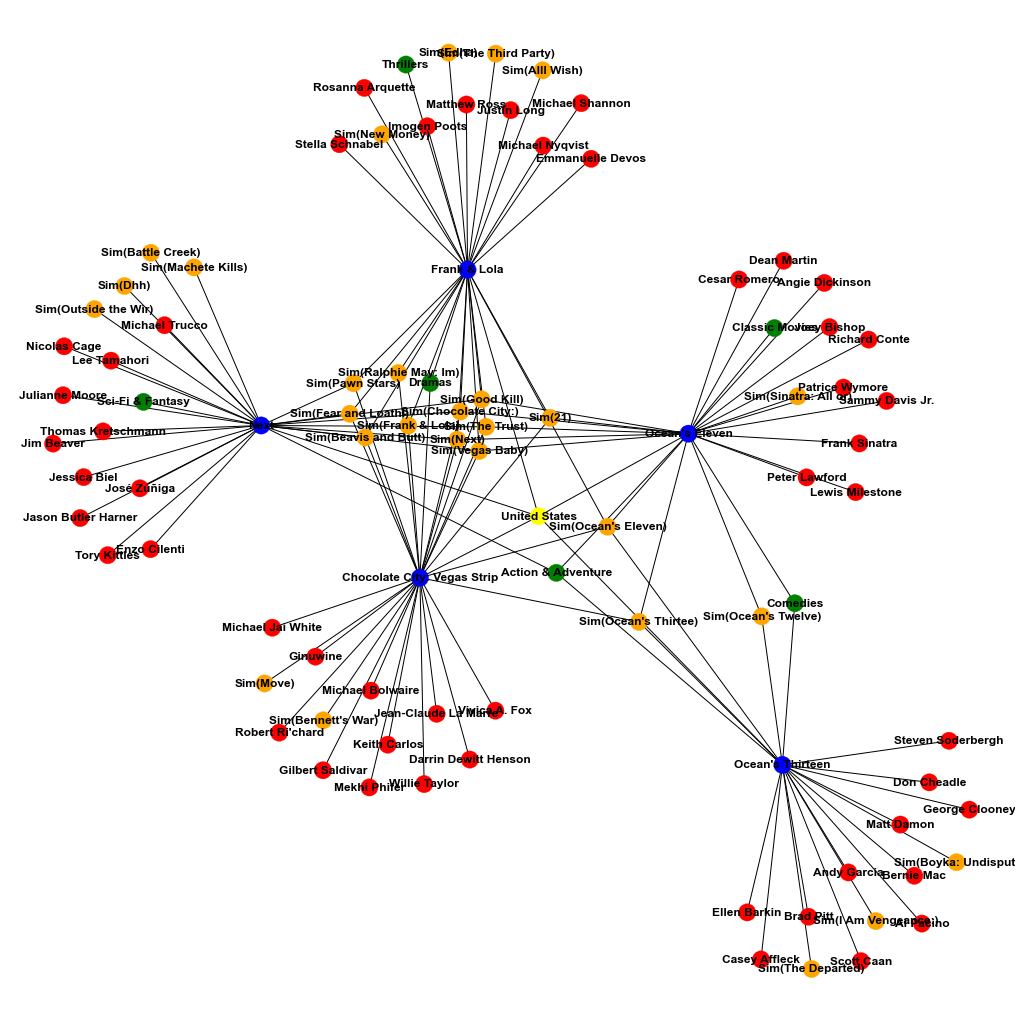

In [111]:
reco=list(result.index[:4].values)
reco.extend(["Ocean's Eleven"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

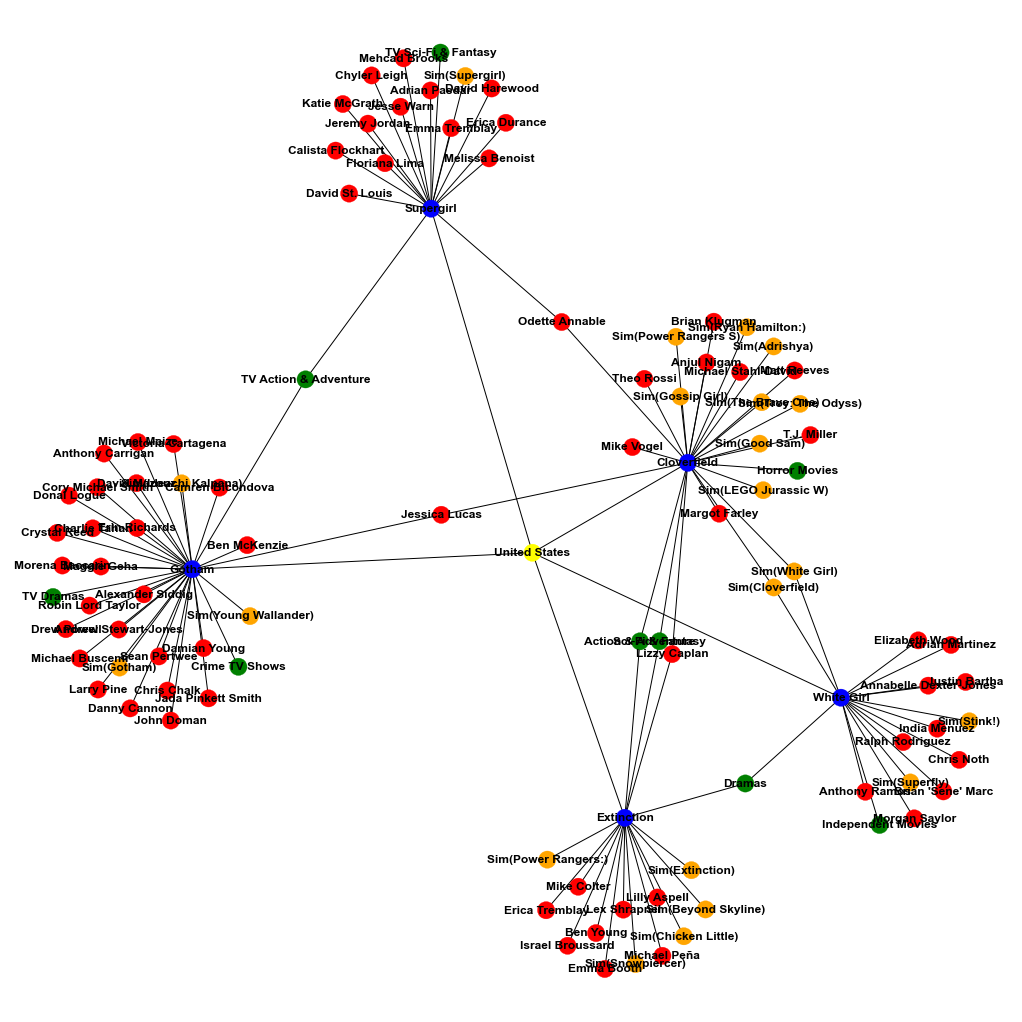

In [114]:
reco=list(result2.index[:4].values)
reco.extend(["Cloverfield"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

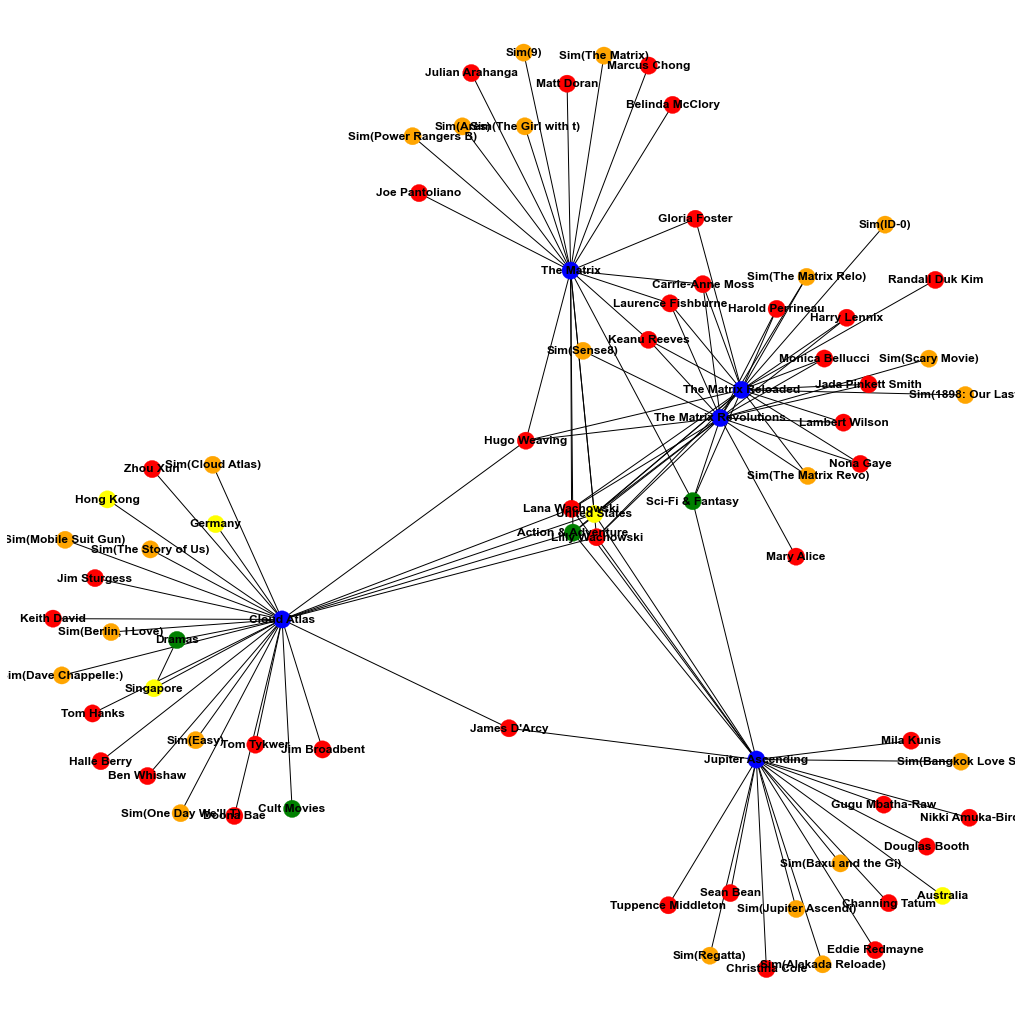

In [115]:
reco=list(result3.index[:4].values)
reco.extend(["The Matrix"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

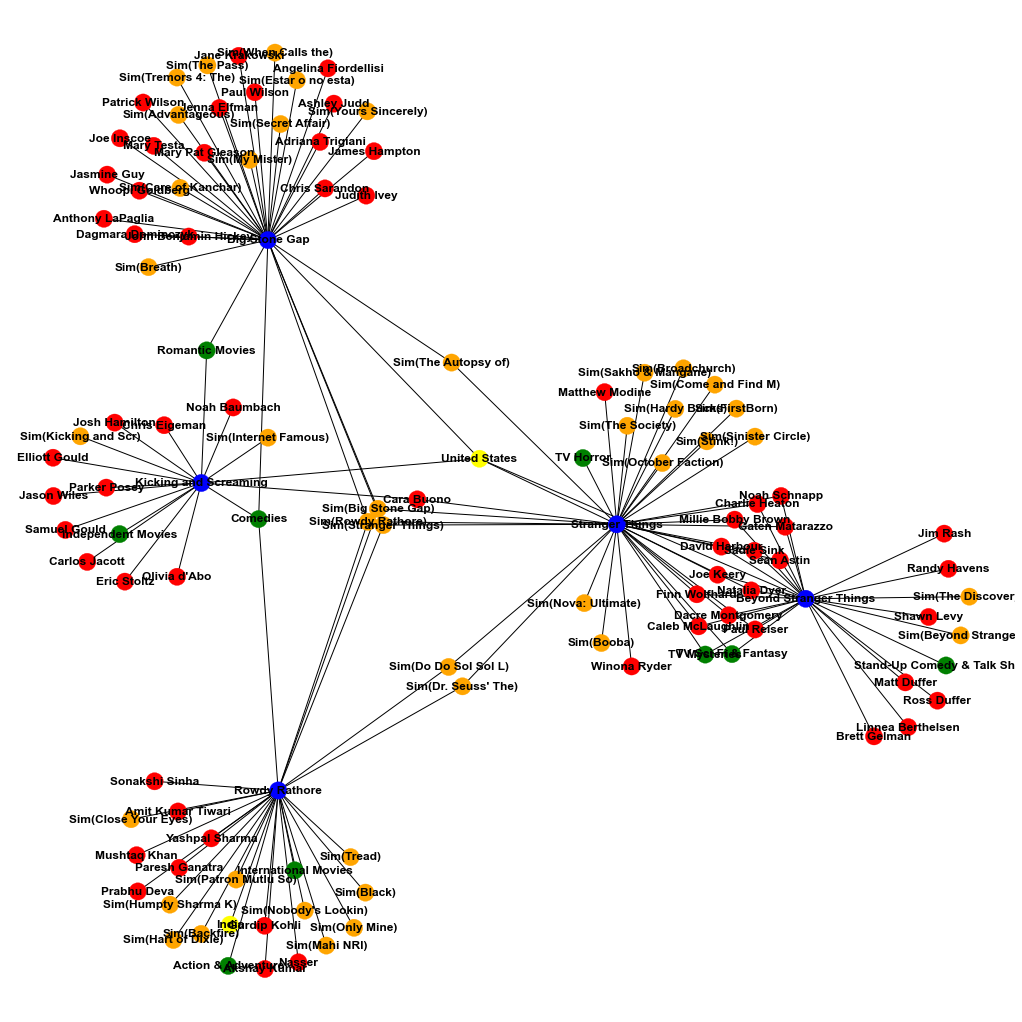

In [52]:
reco=list(result4.index[:4].values)
reco.extend(["Stranger Things"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)